# Import the necessary libraries

In [1]:
import os
from shutil import copyfile
import random
import shutil
from google.colab import files
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor


import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns

%matplotlib inline
sns.set()

# Prepare the data

In [2]:
# Assign training and validation set directories
root_dir = '/content/drive/MyDrive/dataset/Dataset_Detection_of_Lung_Infection/data'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

# Directory with training healthy pictures
train_healthy_dir = os.path.join(train_dir, 'Healthy')
# Directory with training type1 pictures
train_type1_dir = os.path.join(train_dir, 'Type 1 disease')
# Directory with training type2 pictures
train_type2_dir = os.path.join(train_dir, 'Type 2 disease')

# Directory with training healthy pictures
test_healthy_dir = os.path.join(train_dir, 'Healthy')
# Directory with training type1 pictures
test_type1_dir = os.path.join(train_dir, 'Type 1 disease')
# Directory with training type2 pictures
test_type2_dir = os.path.join(train_dir, 'Type 2 disease')

In [3]:
print(f"There are {len(os.listdir(train_healthy_dir))} images of healthy for train")
print(f"There are {len(os.listdir(train_type1_dir))} images of type 1 disease for train")
print(f"There are {len(os.listdir(train_type2_dir))} images of type 2 disease for train")

print(f"There are {len(os.listdir(test_healthy_dir))} images of healthy for test")
print(f"There are {len(os.listdir(test_type1_dir))} images of type 1 disease for test")
print(f"There are {len(os.listdir(test_type2_dir))} images of type 2 disease for test")

There are 70 images of healthy for train
There are 114 images of type 1 disease for train
There are 70 images of type 2 disease for train
There are 70 images of healthy for test
There are 114 images of type 1 disease for test
There are 70 images of type 2 disease for test


# Plot the sample images for all the classes 

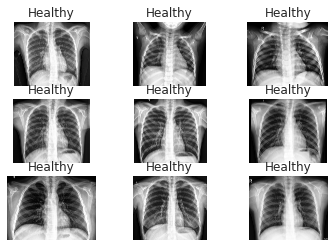

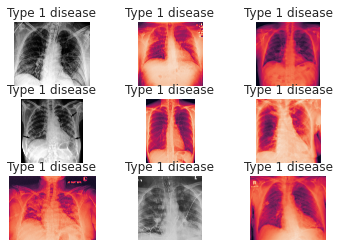

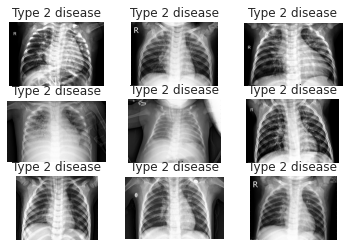

In [4]:
# get all subdirectories in directory
subdirs = [subdir for subdir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, subdir))]

# loop through subdirectories
for subdir in subdirs:
    # get all files in subdirectory
    files = os.listdir(os.path.join(train_dir, subdir))

    # plot first 9 files in subdirectory
    for i in range(9):
        img = Image.open(os.path.join(train_dir, subdir, files[i]))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(subdir)
        plt.axis('off')

    plt.show()

# Plot the distribution of images across the classes

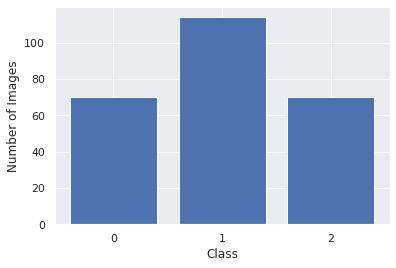

In [5]:
# Calculate the number of images in each class
counts = np.array([70, 114, 70])

# Plot a bar chart of the distribution of images across the classes
plt.bar(range(3), counts)
plt.xticks(range(3))
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# 0 -> Healthy
# 1 -> Type 1
# 2 -> Type 2

# Build a data augmentation for train data to create new data with translation, rescale and flip, and rotation transformations. Rescale the image at 48x48 AND Read images directly from the train folder and test folder using the appropriate function

In [6]:
# train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='nearest')
  


  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(48, 48))
  # train_generator = train_generator.repeat()
  # train_generator = train_generator.repeat()

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(48, 48))
  
  return train_generator, test_generator

In [7]:
train_generator, test_generator = train_val_generators(train_dir, test_dir)

# get a batch of images from the generator
train_images, train_labels = train_generator.next()
test_images, test_labels = test_generator.next()
print(type(train_images))
print(type(train_labels))
print(train_images.shape)
print(train_labels.shape)

Found 254 images belonging to 3 classes.
Found 254 images belonging to 3 classes.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(32, 48, 48, 3)
(32, 3)


In [8]:
print(train_generator.filenames)
print(train_generator.classes)
print(train_generator.class_indices)
print(train_generator.image_shape)
print(train_generator.num_classes)
print(train_generator.batch_size)
print(train_generator.samples)

['Healthy/01.jpeg', 'Healthy/010.jpeg', 'Healthy/011.jpeg', 'Healthy/012.jpeg', 'Healthy/013.jpeg', 'Healthy/014.jpeg', 'Healthy/015.jpeg', 'Healthy/016.jpeg', 'Healthy/017.jpeg', 'Healthy/018.jpeg', 'Healthy/019.jpeg', 'Healthy/02.jpeg', 'Healthy/020.jpeg', 'Healthy/021.jpeg', 'Healthy/022.jpeg', 'Healthy/023.jpeg', 'Healthy/024.jpeg', 'Healthy/025.jpeg', 'Healthy/03.jpeg', 'Healthy/04.jpeg', 'Healthy/05.jpeg', 'Healthy/050.jpeg', 'Healthy/051.jpeg', 'Healthy/052.jpeg', 'Healthy/053.jpeg', 'Healthy/054.jpeg', 'Healthy/055.jpeg', 'Healthy/056.jpeg', 'Healthy/057.jpeg', 'Healthy/058.jpeg', 'Healthy/059.jpeg', 'Healthy/06.jpeg', 'Healthy/060.jpeg', 'Healthy/061.jpeg', 'Healthy/062.jpeg', 'Healthy/063.jpeg', 'Healthy/064.jpeg', 'Healthy/065.jpeg', 'Healthy/066.jpeg', 'Healthy/067.jpeg', 'Healthy/068.jpeg', 'Healthy/069.jpeg', 'Healthy/07.jpeg', 'Healthy/070.jpeg', 'Healthy/071.jpeg', 'Healthy/072.jpeg', 'Healthy/073.jpeg', 'Healthy/074.jpeg', 'Healthy/075.jpeg', 'Healthy/076.jpeg', 'Healt

# CNN Architecture

In [9]:
# Identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [10]:
# Convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [11]:
# ResNet50

def ResNet50(input_shape = (48, 48, 3), classes = 3):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = Dropout(0.2)(X) # New

    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = Dropout(0.2)(X) # New

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048]) 

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X =  AveragePooling2D((2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    # Compile model
    model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])

    return model

model = ResNet50()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [12]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(
      train_generator,
      # steps_per_epoch = 20,
      epochs=10,
      verbose=1,
      validation_data = test_generator,
      # validation_steps = test_generator.samples,
      callbacks=[early_stop])

Epoch 1/10
8/8 [==============================] - 58s 3s/step - loss: 1.3842 - accuracy: 0.4921 - val_loss: 0.9960 - val_accuracy: 0.5157
Epoch 2/10
8/8 [==============================] - 26s 3s/step - loss: 1.2949 - accuracy: 0.5157 - val_loss: 1.1577 - val_accuracy: 0.5906
Epoch 3/10
8/8 [==============================] - 24s 3s/step - loss: 1.1183 - accuracy: 0.5787 - val_loss: 0.9549 - val_accuracy: 0.6299
Epoch 4/10
8/8 [==============================] - 25s 3s/step - loss: 1.0363 - accuracy: 0.5512 - val_loss: 0.9037 - val_accuracy: 0.6181
Epoch 5/10
8/8 [==============================] - 32s 4s/step - loss: 0.9975 - accuracy: 0.5827 - val_loss: 0.9537 - val_accuracy: 0.6260
Epoch 6/10
8/8 [==============================] - 25s 3s/step - loss: 1.0301 - accuracy: 0.5591 - val_loss: 0.9962 - val_accuracy: 0.5945


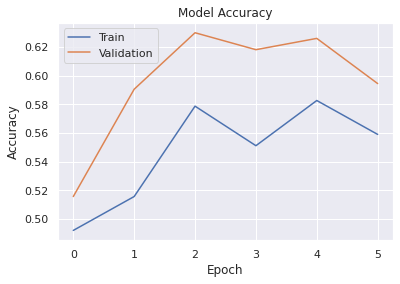

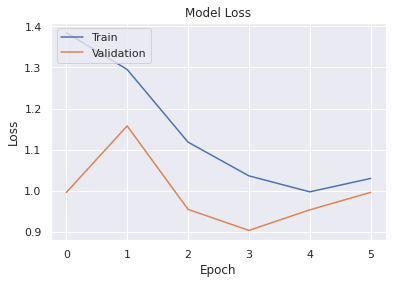

In [14]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

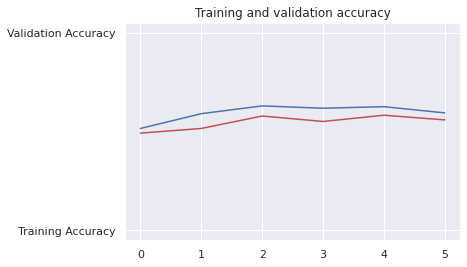

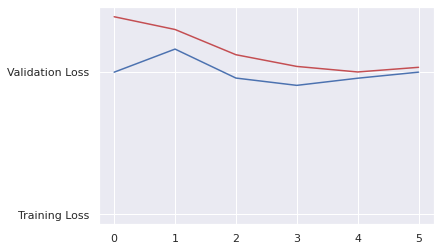

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [17]:
# Print precision, recall, and F1-score for all classes
from sklearn.metrics import classification_report

test_generator.reset()
y_pred = model.predict(test_generator)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=class_labels))

8/8 [==============================] - 11s 1s/step
                precision    recall  f1-score   support

       Healthy       0.29      0.24      0.26        70
Type 1 disease       0.46      0.54      0.50       114
Type 2 disease       0.30      0.26      0.28        70

      accuracy                           0.38       254
     macro avg       0.35      0.35      0.35       254
  weighted avg       0.37      0.38      0.37       254



# I don't have a test data so I will use the same data that is used in validation for testing

# Transfer learning using mobile net

In [18]:
def MobileNet_V2(input_shape = (48, 48, 3), classes = 3):
    
  # Create an instance of pre-trained mobile net model
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')

  # Add dense, dropout and batch normalization layers on the pre-trained model
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  predictions = Dense(classes, activation='softmax')(x)

  # Create final output layer with SoftMax activation function
  model = Model(inputs=base_model.input, outputs=predictions)

  # Change batch size, activation function and optimize as rmsprop
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model = MobileNet_V2()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 24, 24, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 24, 24, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

In [19]:
tf.keras.utils.plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Use early stopping with the patience of two epoch and call back function for preventing overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Train the model using a generator and test accuracy of test data at every epoch
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[early_stopping])


<ipython-input-20-3ff4647e627d>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
7/7 [==============================] - 62s 6s/step - loss: 1.5456 - accuracy: 0.5000 - val_loss: 2.5252 - val_accuracy: 0.5580
Epoch 2/10
7/7 [==============================] - 34s 5s/step - loss: 1.2703 - accuracy: 0.6036 - val_loss: 1.4575 - val_accuracy: 0.5804
Epoch 3/10
7/7 [==============================] - 33s 5s/step - loss: 1.3652 - accuracy: 0.5901 - val_loss: 1.0603 - val_accuracy: 0.6562
Epoch 4/10
7/7 [==============================] - 22s 3s/step - loss: 1.0896 - accuracy: 0.6396 - val_loss: 1.6691 - val_accuracy: 0.6562
Epoch 5/10
7/7 [==============================] - 31s 5s/step - loss: 0.8740 - accuracy: 0.7432 - val_loss: 3.0264 - val_accuracy: 0.5670


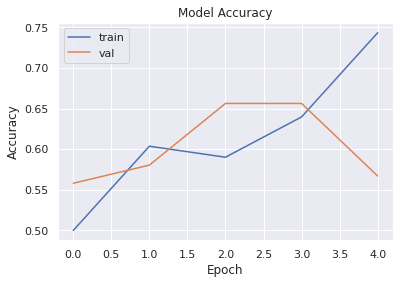

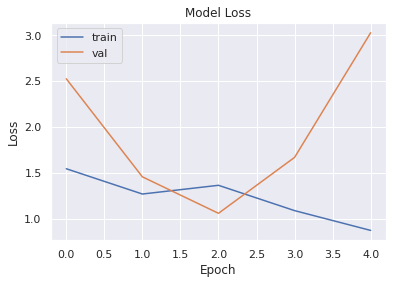

In [21]:
# Plot training and validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# # Evaluate the model on the test data
# test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // test_generator.batch_size)
# print('Test accuracy:', test_acc)

# # Obtain precision, recall, and F1-score for all classes for both grayscale and color models
# Y_pred = model.predict_generator(test_generator, steps=test_generator.samples // test_generator.batch_size+1)
# y_pred = np.argmax(Y_pred, axis=1)

In [22]:
# Print precision, recall, and F1-score for all classes

test_generator.reset()
y_pred = model.predict(test_generator)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=class_labels))

8/8 [==============================] - 12s 1s/step
                precision    recall  f1-score   support

       Healthy       1.00      0.01      0.03        70
Type 1 disease       0.45      0.78      0.57       114
Type 2 disease       0.29      0.23      0.26        70

      accuracy                           0.42       254
     macro avg       0.58      0.34      0.28       254
  weighted avg       0.56      0.42      0.33       254



# Transfer Learning using Densenet121

In [23]:
def DenseNet121(input_shape = (48, 48, 3), classes = 3):
    
  # Create an instance of a pre-trained model - DenseNet121
  base_model = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet')

  # Freeze the top layers of the pre-trained model
  for layer in base_model.layers:
      layer.trainable = False

  # Add a dense layer and dropout layer
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.2)(x)
  predictions = Dense(classes, activation='softmax')(x)

  # Create the final model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model = DenseNet121()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 54, 54, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 24, 24, 64)   9408        ['zero_padding2d_1[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1/conv[0][0]']       

In [24]:
tf.keras.utils.plot_model(model, to_file='model_3.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    batch_size=7,
                    validation_data=test_generator,
                    callbacks=[early_stop])

Epoch 1/15
8/8 [==============================] - 35s 4s/step - loss: 0.9839 - accuracy: 0.5157 - val_loss: 0.5347 - val_accuracy: 0.8189
Epoch 2/15
8/8 [==============================] - 24s 3s/step - loss: 0.7047 - accuracy: 0.7402 - val_loss: 0.7290 - val_accuracy: 0.7087
Epoch 3/15
8/8 [==============================] - 25s 3s/step - loss: 0.6502 - accuracy: 0.7480 - val_loss: 0.5143 - val_accuracy: 0.8031
Epoch 4/15
8/8 [==============================] - 25s 3s/step - loss: 0.5905 - accuracy: 0.7402 - val_loss: 0.6392 - val_accuracy: 0.7362
Epoch 5/15
8/8 [==============================] - 22s 3s/step - loss: 0.5779 - accuracy: 0.7835 - val_loss: 0.5092 - val_accuracy: 0.7953
Epoch 6/15
8/8 [==============================] - 25s 3s/step - loss: 0.5449 - accuracy: 0.7913 - val_loss: 0.5632 - val_accuracy: 0.7717
Epoch 7/15
8/8 [==============================] - 24s 3s/step - loss: 0.4818 - accuracy: 0.8071 - val_loss: 0.3539 - val_accuracy: 0.8740
Epoch 8/15
8/8 [==================

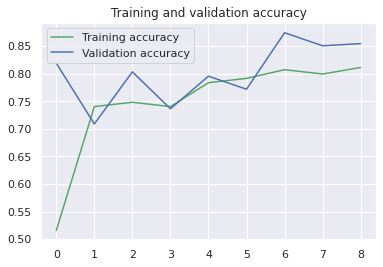

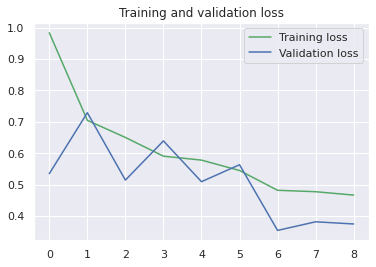

In [26]:
# Plot training and validation accuracy, and loss
epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, history.history['loss'], 'g', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [27]:
# Print precision, recall, and F1-score for all classes

test_generator.reset()
y_pred = model.predict(test_generator)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=class_labels))

8/8 [==============================] - 15s 2s/step
                precision    recall  f1-score   support

       Healthy       0.28      0.31      0.29        70
Type 1 disease       0.46      0.44      0.45       114
Type 2 disease       0.32      0.30      0.31        70

      accuracy                           0.37       254
     macro avg       0.35      0.35      0.35       254
  weighted avg       0.37      0.37      0.37       254



In [31]:
!jupyter nbconvert --to html LungDetection.html /content/drive/MyDrive/NOTEBOOKS/Colab_Notebooks/Advanced_Computer_Vision.ipynb

[NbConvertApp] WARNING | pattern 'LungDetection.html' matched no files
[NbConvertApp] Converting notebook /content/drive/MyDrive/NOTEBOOKS/Colab_Notebooks/Advanced_Computer_Vision.ipynb to html
[NbConvertApp] Writing 1425482 bytes to /content/drive/MyDrive/NOTEBOOKS/Colab_Notebooks/Advanced_Computer_Vision.html
